<h1>Preparation</h1>
The data we selected is a corpus of 14,500 tweets about customer experiences with airlines. The data is labeled for sentiment analysis, either positive, negative, or neutral, which allows us to perform a supervised learning with the data and hopefully classify the tweets accordingly. As twitter supports unicode (to include emoji and other special characters), we wanted to tokenize using a vocabulary that is robust to characters and words outside a conventional English dictionary. To do this, we onehot encoded each word based on a vocabulary size of unique words in our dataset - where any unique combination of unicode characters constituted a word. Similarly, we onehot encoded our 3 class labels using sklearn's preprocessing tools. Finally, before feeding our data to our models, we had to clip and pad the entries to make them uniform in length. We chose 140 words as our length. The character limit of a tweet is 280, counting spaces. Because of this, if a person were to compose a tweet of one character words, the maximum length of that tweet is 140 words. This ensures that we never lose information, which is the lesser of evils when comapred to 0 padding our data.

<h1>Train and Test</h1>
Our data is well labeled, but we have a (not so) slight class imbalance problem. As is shown below, 61% of the tweets about airlines are negative. As surprising as this fact was to us, we understood that it was a possibility and planned to deal with it. By stratifying the data when splitting into train and test sets, we ensure that both train and test sets have similar distributions of positive, neutral, and negative tweets. This helps us when computing validation accuracy scores during our training runs, but still does not solve the class imbalance problem. Because our corpus is sufficiently large, a stratified k-fold cross validation seems unnecessary. We instead chose to use a weighted accuracy metric to validate our models. This metric ensures that the network is not learning to blindly guess the class which will yield the highest probablility of correctness, but rather is looking at the data and making informed classificaton of the inputs. To do this, we used sklearn's built in accuracy score, and supplied a weight matrix consisting of the inverse of the proportions of each class. That is, if a class made up 60% of the test data, we would use 1/.6 as a weight for that class.

In [1]:
#prepare data and class variables
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot, text_to_word_sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

tweets_df = pd.read_csv('../tweets.csv')

p_weight = float(len(tweets_df[tweets_df['airline_sentiment'] == 'positive']))/len(tweets_df)
n_weight = float(len(tweets_df[tweets_df['airline_sentiment'] == 'neutral']))/len(tweets_df)
neg_weight = float(len(tweets_df[tweets_df['airline_sentiment'] == 'negative']))/len(tweets_df)
print('positive', p_weight)
print('neutral', n_weight)
print('negative', neg_weight)

tweets_df[tweets_df['airline_sentiment'] == 'positive']['airline_sentiment'] = 0
tweets_df[tweets_df['airline_sentiment'] == 'neutral']['airline_sentiment'] = 1
tweets_df[tweets_df['airline_sentiment'] == 'positive']['airline_sentiment'] = 2

X = tweets_df['text'].tolist()
y = tweets_df['airline_sentiment'].tolist()

y_weights = []


encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_Y)
y = dummy_y

vocab_size = 0
for entry in X:
    words = set(text_to_word_sequence(entry))
    vocab_size += len(words)
    
X = [one_hot(entry, round(vocab_size*1.3)) for entry in X]

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, random_state=42, stratify=dummy_y)

for t in y_test:
    if np.argmax(t) == 0:
        y_weights.append(1./p_weight)
    if np.argmax(t) == 1:
        y_weights.append(1./n_weight)
    if np.argmax(t) == 2:
        y_weights.append(1./neg_weight)
        
X_train = sequence.pad_sequences(X_train, maxlen=140)
X_test = sequence.pad_sequences(X_test, maxlen=140)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

def weighted_accuracy(y_test, y_pred):
    y_pred = [np.argmax(y_t) for y_t in y_pred]
    y_test = [np.argmax(y_t) for y_t in y_test]
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test, y_pred, sample_weight=y_weights)
def summarize_net(y_test, y_pred, title_text=''):
    import seaborn as sns
    import sklearn.metrics as mt
    print("Weighted Accuracy:",weighted_accuracy(y_test, y_pred))
    y_pred = [np.argmax(y_t) for y_t in y_pred]
    y_test = [np.argmax(y_t) for y_t in y_test]
    plt.figure(figsize=(15,5))
    acc = mt.accuracy_score(y_test,y_pred)
    cm = mt.confusion_matrix(y_test,y_pred)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis].astype(np.float16)
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text)

Using TensorFlow backend.


('positive', 0.16140710382513662)
('neutral', 0.21168032786885246)
('negative', 0.6269125683060109)


/home/labuser/anaconda2/envs/deep_corr/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/labuser/anaconda2/envs/deep_corr/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/labuser/anaconda2/envs/deep_corr/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

<h1>Modeling</h1>
Our network architectures chosen were first one RNN layer, followed by a softmax layer for classifcation. We used SimpleRNN, LSTM, and GRU layers for this model. However, this model was not performing as well as we had hoped. The model was not performing well for the 'neutral' case, and was showing signs of overfitting. In an effort to generalize better to validation data, we added a dense layer with dropout before the softmax, and increased the dropout and recurrent dropout. We used the same 3 RNN layers for this architecture. This second architecture showed some improvement, but was still inadequate. It is worth noting that the LSTM and GRU networks performed similarly in these conditions. Finally, for our last architecture, we used 2 LSTM layers, followed by a dense layer, and then a softmax. Our previous model had begun to overfit to the data, so we increased dropout in the final layer in this architecture. For our training procedure, we decided to keep each consistent for most equitable comparison between the models. We used 10 epochs, with a batch size of 32. This model seemed to converge, even overfitting a bit in the end epochs for some architectures. 

Our visualizations were seaborn confusion matrices and plots of our loss over training runs. Based on these,  we can conclude that LSTM models with multiple RNN layers performed best overall, with that same architecture with multiple dense layers performing second best.

In [2]:
from keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Dropout, Embedding
from keras.models import Model
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))

for func in [SimpleRNN, LSTM, GRU]:
    input_embed = Embedding(vocab_size,
                       50,
                       input_length=140)(input_holder)
    x = func(50, dropout=0.2, recurrent_dropout=0.2)(input_embed)
    x = Dense(3, activation='softmax')(x)
    rnn=Model(inputs=input_holder, outputs=x)
    rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(rnn.summary())
    rnns.append(rnn)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 50)           12416200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 12,421,403
Trainable params: 12,421,403
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Laye

In [3]:
history={}
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    history[name]=rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

('=======', 'simple', '========')
Instructions for updating:
Use tf.cast instead.
Train on 10980 samples, validate on 3660 samples
Epoch 1/10
10980/10980 [==============================] - 20s 2ms/step - loss: 0.9774 - acc: 0.5619 - val_loss: 0.8705 - val_acc: 0.6284
Epoch 2/10
10980/10980 [==============================] - 18s 2ms/step - loss: 0.8447 - acc: 0.6449 - val_loss: 0.8540 - val_acc: 0.6421
Epoch 3/10
10980/10980 [==============================] - 18s 2ms/step - loss: 0.7325 - acc: 0.6944 - val_loss: 0.7284 - val_acc: 0.6929
Epoch 4/10
10980/10980 [==============================] - 18s 2ms/step - loss: 0.6244 - acc: 0.7539 - val_loss: 0.7255 - val_acc: 0.7183
Epoch 5/10
10980/10980 [==============================] - 18s 2ms/step - loss: 0.5287 - acc: 0.7958 - val_loss: 0.7084 - val_acc: 0.7257
Epoch 6/10
10980/10980 [==============================] - 18s 2ms/step - loss: 0.4518 - acc: 0.8224 - val_loss: 0.7295 - val_acc: 0.7235
Epoch 7/10
10980/10980 [=======================

('=======', 'simple', '========')
('Weighted Accuracy:', 0.77006506453810353)
('=======', 'lstm', '========')
('Weighted Accuracy:', 0.79537211030524613)
('=======', 'gru', '========')
('Weighted Accuracy:', 0.78106743594628791)


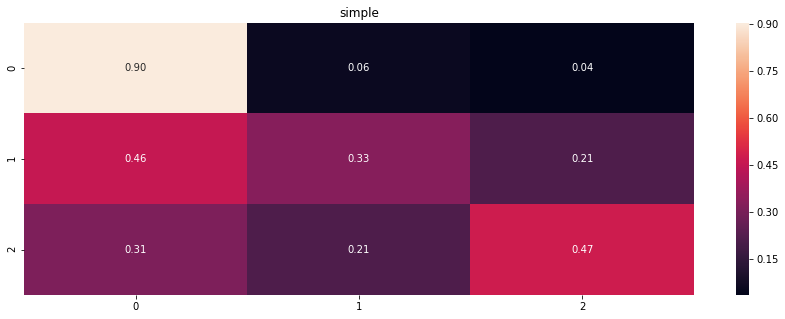

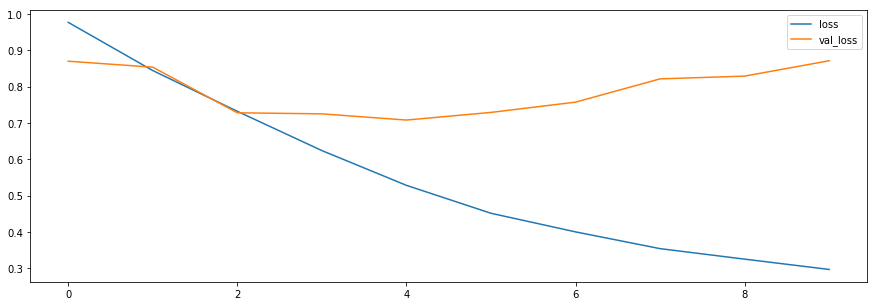

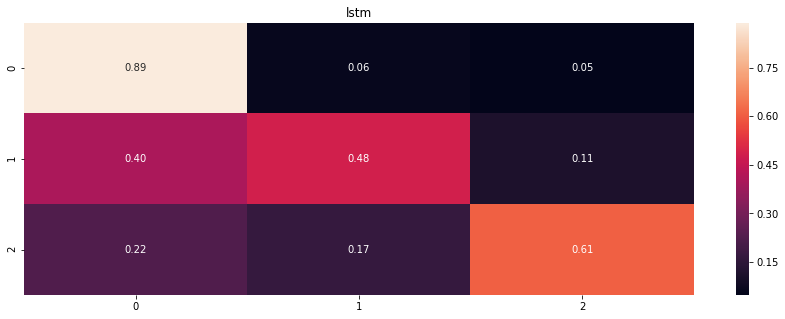

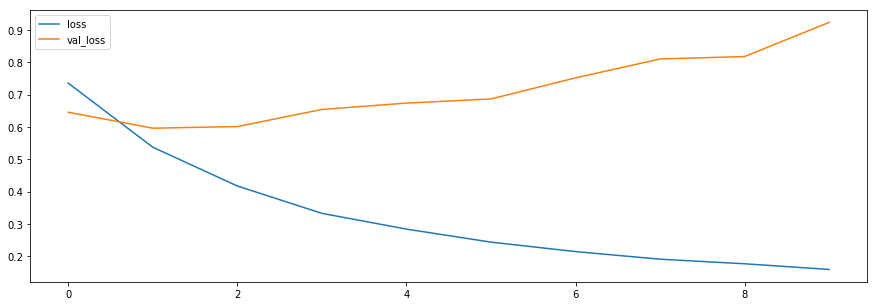

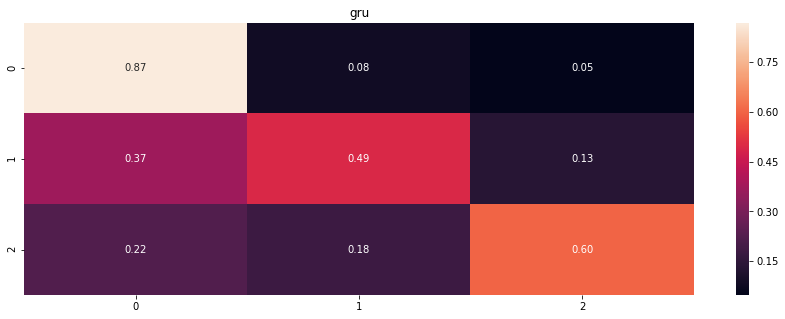

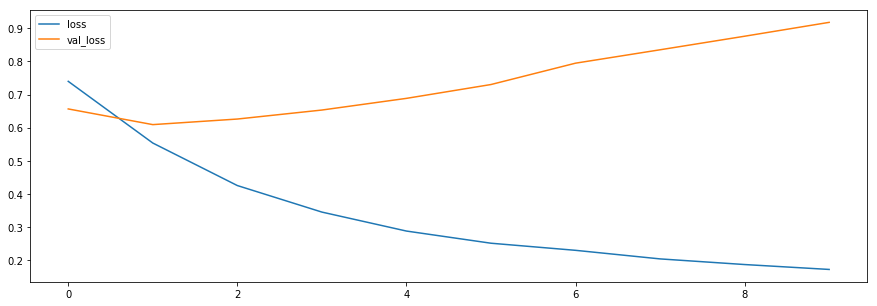

In [4]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    y_pred = rnn.predict(X_test)
    summarize_net(y_test, y_pred, name)
    plt.figure(figsize=(15,5))
    plt.plot(history[name].history['loss'], label="loss")
    plt.plot(history[name].history['val_loss'], label="val_loss")
    plt.legend()

In [5]:
# input_holder = Input(shape=(X_train.shape[1], ))
rnns=[]
for func in [SimpleRNN, LSTM, GRU]:
    input_embed_ = Embedding(vocab_size,
                       50,
                       input_length=140)(input_holder)
    x = func(50, dropout=0.25, recurrent_dropout=0.25)(input_embed_)
    x = Dense(15, activation='relu')(x)
    x = Dropout(0.3, seed=42)(x)
    x = Dense(3, activation='softmax')(x)
    rnn=Model(inputs=input_holder, outputs=x)
    rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(rnn.summary())
    rnns.append(rnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 140, 50)           12416200  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                765       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 48        
Total params: 12,422,063
Trainable params: 12,422,063
Non-trainable params: 0
________________________________________________________________

In [6]:
history_2 = {}
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    history_2[name] = rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

('=======', 'simple', '========')
Train on 10980 samples, validate on 3660 samples
Epoch 1/10
10980/10980 [==============================] - 19s 2ms/step - loss: 1.0067 - acc: 0.5508 - val_loss: 0.9097 - val_acc: 0.6268
Epoch 2/10
10980/10980 [==============================] - 20s 2ms/step - loss: 0.9337 - acc: 0.6248 - val_loss: 0.8998 - val_acc: 0.6268
Epoch 3/10
10980/10980 [==============================] - 22s 2ms/step - loss: 0.9069 - acc: 0.6274 - val_loss: 0.8805 - val_acc: 0.6268
Epoch 4/10
10980/10980 [==============================] - 23s 2ms/step - loss: 0.8944 - acc: 0.6270 - val_loss: 0.8760 - val_acc: 0.6268
Epoch 5/10
10980/10980 [==============================] - 20s 2ms/step - loss: 0.8538 - acc: 0.6296 - val_loss: 0.8572 - val_acc: 0.6317
Epoch 6/10
10980/10980 [==============================] - 19s 2ms/step - loss: 0.8013 - acc: 0.6454 - val_loss: 0.8600 - val_acc: 0.6317
Epoch 7/10
10980/10980 [==============================] - 19s 2ms/step - loss: 0.7619 - acc: 0.

('=======', 'simple', '========')
('Weighted Accuracy:', 0.7239390967420426)
('=======', 'lstm', '========')
('Weighted Accuracy:', 0.78958628752470961)
('=======', 'gru', '========')
('Weighted Accuracy:', 0.77485430187979254)


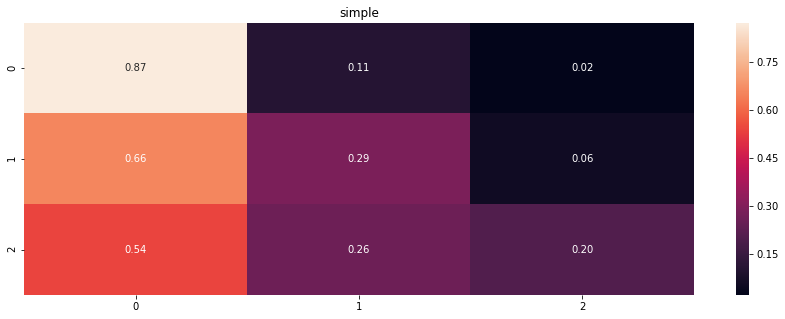

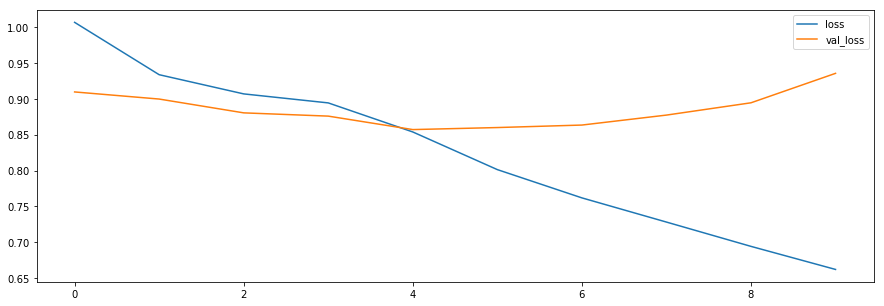

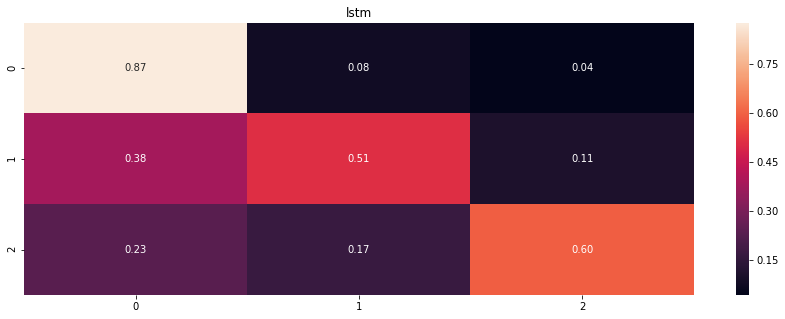

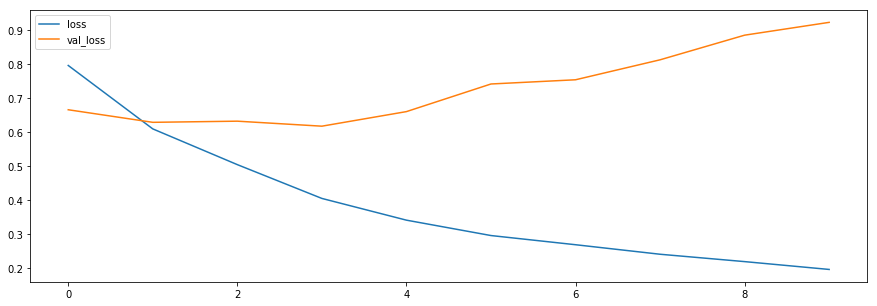

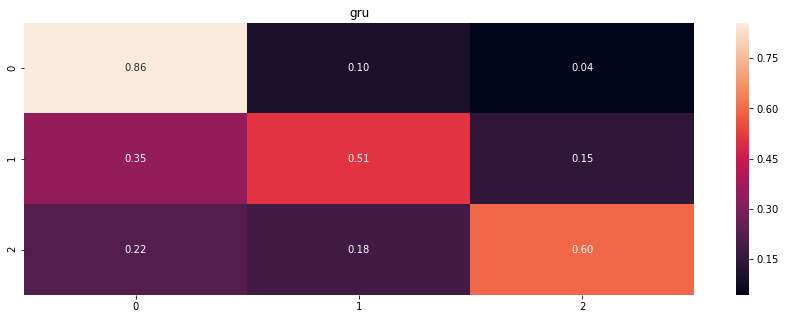

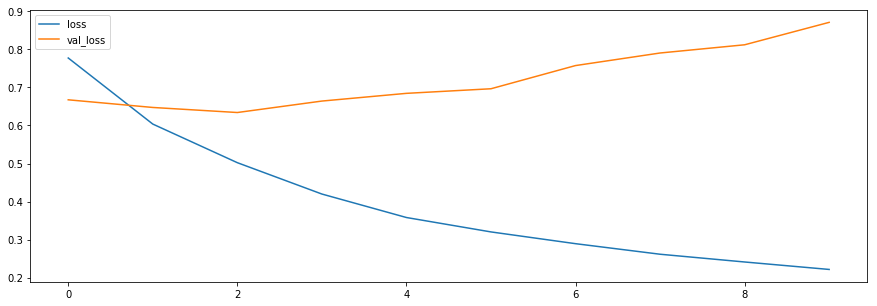

In [7]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    y_pred = rnn.predict(X_test)
    summarize_net(y_test, y_pred, name)
    plt.figure(figsize=(15,5))
    plt.plot(history_2[name].history['loss'], label="loss")
    plt.plot(history_2[name].history['val_loss'], label="val_loss")
    plt.legend()

In [8]:
EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(vocab_size,
                       50,
                       input_length=140)(input_holder)
x = LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input_embed)
x = LSTM(25, dropout=0.4, recurrent_dropout=0.4)(x)
x = Dense(15, activation='sigmoid')(x)
x = Dropout(0.3, seed=42)(x)
x = Dense(3, activation='softmax')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
rnn.summary()
history3 = rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 140, 50)           12416200  
_________________________________________________________________
lstm_3 (LSTM)                (None, 140, 50)           20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_10 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_4 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 48        
Total para

('Weighted Accuracy:', 0.77697867501659956)


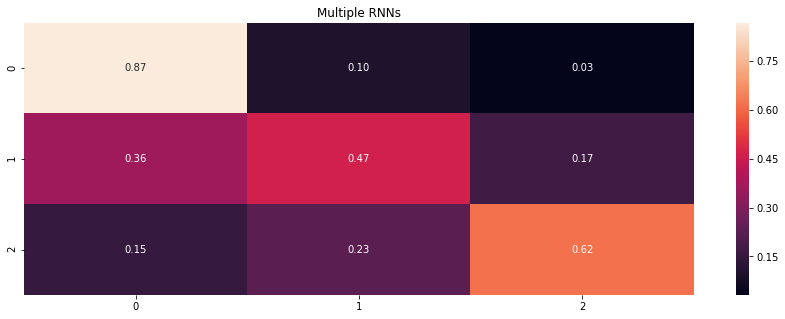

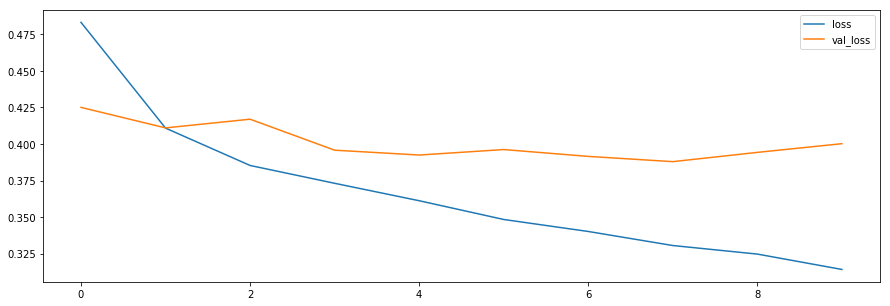

In [9]:
from sklearn.metrics import confusion_matrix
y_pred = rnn.predict(X_test)
summarize_net(y_test, y_pred, "Multiple RNNs")
plt.figure(figsize=(15,5))
plt.plot(history3.history['loss'], label="loss")
plt.plot(history3.history['val_loss'], label="val_loss")
plt.legend()

<h1>Exceptional Work</h1>
Participating in Research Study